# Recommendation Service End-to-End Testing

This notebook tests the full integration flow: **AI Image Analysis -> Pet Profile Creation -> Personalized Recommendations**

## Architecture Overview

```
Image Upload -> AI Service (species/breed detection)
                    |
                    v
Pet Profile Creation (user-service)
                    |
                    v
Recommendation Service (content-based filtering)
                    |
                    v
Ranked Products with match reasons + scores
```

## Prerequisites

- [ ] All services running: `make up`
- [ ] Init rag knowledge base: `make rag`
- [ ] Tables migrated: `make migration`
- [ ] Products seeded: `make seed`
- [ ] Test image in `test_data/images/` directory

In [3]:
import requests, json, base64, os
from pathlib import Path
from PIL import Image
from IPython.display import display
import pandas as pd

# Configuration
API_GATEWAY_URL = "http://localhost:8001"
TEST_IMAGES_DIR = Path("test_data/images")
TEST_USER_EMAIL = "test_recommendations@example.com"
TEST_USER_PASSWORD = "testpassword123"

# Session for maintaining JWT cookies
session = requests.Session()

# Image formats
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.webp', '.bmp'}

print("Setup complete")
print(f"API Gateway: {API_GATEWAY_URL}")
print(f"Test images: {TEST_IMAGES_DIR.absolute()}")

Setup complete
API Gateway: http://localhost:8001
Test images: /home/crea/Desktop/ft_transcendence/scripts/jupyter/test_data/images


## 1. Authentication

Register a test user (or login if exists). Session maintains JWT cookie for subsequent requests.

In [4]:
def login():
    """Login a test user."""
    try:
        response = session.post(
            f"{API_GATEWAY_URL}/api/v1/auth/login",
            json={"email": TEST_USER_EMAIL, "password": TEST_USER_PASSWORD},
            timeout=10
        )
        if response.status_code == 200:
            print(f"Login successful: {TEST_USER_EMAIL}")
            return True
        else:
            print(f"Login failed: {response.status_code}")
            return False
    except requests.exceptions.ConnectionError:
        print("Cannot connect to API Gateway. Make sure services are running.")
        return False

def register():
    """Register a test user (or login if already exists)."""
    try:
        response = session.post(
            f"{API_GATEWAY_URL}/api/v1/auth/register",
            json={"email": TEST_USER_EMAIL, "password": TEST_USER_PASSWORD},
            timeout=10
        )
        if response.status_code == 201:
            print(f"Registration successful: {TEST_USER_EMAIL}")
            return True
        elif response.status_code == 409:  # Already exists
            return login()
        else:
            print(f"Registration failed: {response.status_code} - {response.text[:200]}")
            return False
    except requests.exceptions.ConnectionError:
        print("Cannot connect to API Gateway. Make sure services are running.")
        return False

# Authenticate
auth_success = register()
if not auth_success:
    raise SystemExit("Authentication failed")

Registration successful: test_recommendations@example.com


## 2. AI Analysis

Load the first available image and analyze it using the AI vision pipeline to detect species and breed.

Selected image: WhatsApp Image 2026-02-02 at 22.06.35 (1).jpeg


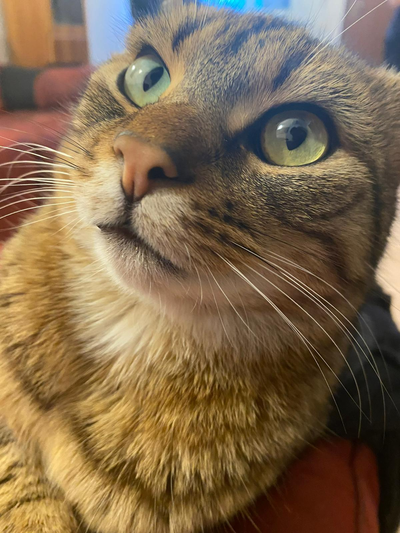


Analyzing image...

AI ANALYSIS RESULTS
Species:    CAT
Breed:      Bengal Egyptian Mau Mix
Confidence: 15.0%
Crossbreed: Yes


In [8]:
# Find first available test image
def find_test_images():
    """Find all image files in the test data directory."""
    if not TEST_IMAGES_DIR.exists():
        return []
    images = []
    for ext in IMAGE_EXTENSIONS:
        images.extend(TEST_IMAGES_DIR.glob(f'*{ext}'))
        images.extend(TEST_IMAGES_DIR.glob(f'*{ext.upper()}'))
    return sorted(images)

def load_image_as_base64(image_path):
    """Load image file and convert to base64 data URI."""
    with open(image_path, 'rb') as f:
        image_data = f.read()
    ext = image_path.suffix.lower().lstrip('.')
    if ext == 'jpg':
        ext = 'jpeg'
    encoded = base64.b64encode(image_data).decode()
    return f"data:image/{ext};base64,{encoded}"

# Find and load image
available_images = find_test_images()
if not available_images:
    raise SystemExit(f"No test images found in {TEST_IMAGES_DIR.absolute()}")

selected_image = available_images[0]
print(f"Selected image: {selected_image.name}")

# Display the image
img = Image.open(selected_image)
if img.width > 400:
    ratio = 400 / img.width
    img = img.resize((400, int(img.height * ratio)), Image.Resampling.LANCZOS)
display(img)

# Convert to base64 and analyze
image_base64 = load_image_as_base64(selected_image)
print(f"\nAnalyzing image...")

response = session.post(
    f"{API_GATEWAY_URL}/api/v1/vision/analyze",
    json={"image": image_base64},
    timeout=120
)

if response.status_code != 200:
    print(f"AI Analysis failed: {response.status_code}")
    print(response.text[:500])
    raise SystemExit("AI Analysis failed")

ai_result = response.json()
ai_data = ai_result.get('data', {})

# Extract key values for pet creation
species = ai_data.get('species', 'unknown')
breed_analysis = ai_data.get('breed_analysis', {})
primary_breed = breed_analysis.get('primary_breed', 'unknown')
confidence = breed_analysis.get('confidence', 0)
is_crossbreed = breed_analysis.get('is_likely_crossbreed', False)

# Display summary
print(f"\n{'='*50}")
print(f"AI ANALYSIS RESULTS")
print(f"{'='*50}")
print(f"Species:    {species.upper()}")
print(f"Breed:      {primary_breed.replace('_', ' ').title()}")
print(f"Confidence: {confidence * 100:.1f}%")
print(f"Crossbreed: {'Yes' if is_crossbreed else 'No'}")
print(f"{'='*50}")

## 3. Pet Creation

Create a pet profile using AI-detected species/breed combined with hardcoded test values.

In [9]:
# Build pet profile from AI results + hardcoded values
# Note: user-service uses 'age' and 'weight' (no unit suffixes)
pet_data = {
    "name": f"TestPet{species.capitalize()}",
    "species": species,
    "breed": primary_breed,
    "age": 24,  # months
    "weight": 5.5,  # kg
    "health_conditions": ["sensitive_stomach"]
}

print("Creating pet profile...")
print(f"  Name: {pet_data['name']}")
print(f"  Species: {pet_data['species']}")
print(f"  Breed: {pet_data['breed']}")
print(f"  Age: {pet_data['age']} months")
print(f"  Weight: {pet_data['weight']} kg")
print(f"  Health: {pet_data['health_conditions']}")

response = session.post(
    f"{API_GATEWAY_URL}/api/v1/users/me/pets",
    json=pet_data,
    timeout=10
)

if response.status_code != 201:
    print(f"\nPet creation failed: {response.status_code}")
    print(response.text[:500])
    raise SystemExit("Pet creation failed")

pet_result = response.json()
pet_id = pet_result.get('data', {}).get('id')

if not pet_id:
    print(f"Could not extract pet_id from response: {pet_result}")
    raise SystemExit("Pet ID not found in response")

print(f"\nPet created successfully!")
print(f"Pet ID: {pet_id}")

Creating pet profile...
  Name: TestPetCat
  Species: cat
  Breed: bengal_egyptian_mau_mix
  Age: 24 months
  Weight: 5.5 kg
  Health: ['sensitive_stomach']

Pet creation failed: 404
{"success": false, "data": null, "error": {"code": "NOT_FOUND", "message": "The requested resource was not found", "details": {}}, "timestamp": "2026-02-06T08:54:30.214147"}


SystemExit: Pet creation failed

## 4. Get Recommendations

Fetch personalized food recommendations for the pet using content-based filtering.

In [ ]:
# Request food recommendations
print(f"Fetching recommendations for pet {pet_id}...")

response = session.get(
    f"{API_GATEWAY_URL}/api/v1/recommendations/food",
    params={"pet_id": pet_id, "limit": 10, "min_score": 0.3},
    timeout=30
)

if response.status_code != 200:
    print(f"Recommendations request failed: {response.status_code}")
    print(response.text[:500])
    raise SystemExit("Recommendations failed")

recommendations_result = response.json()
recommendations_data = recommendations_result.get('data', {})

# Store for display
pet_profile = recommendations_data.get('pet', {})
recommendations = recommendations_data.get('recommendations', [])
metadata = recommendations_data.get('metadata', {})

print(f"Received {len(recommendations)} recommendations")
print(f"Total products evaluated: {metadata.get('total_products_evaluated', 'N/A')}")

## 5. Results Display

Visualize the complete data flow and detailed recommendation breakdown.

In [ ]:
# Part A: Data Flow Summary
top_product = recommendations[0] if recommendations else None
top_product_name = top_product.get('name', 'N/A') if top_product else 'N/A'
top_product_score = top_product.get('similarity_score', 0) if top_product else 0

health_str = ', '.join(pet_profile.get('health_conditions', [])) or 'None'

print("DATA FLOW SUMMARY")
print("=" * 60)
print(f"AI Detection    -> {species.upper()} ({primary_breed.replace('_', ' ').title()}, {confidence * 100:.0f}% confidence)")
print(f"Pet Profile     -> \"{pet_profile.get('name', 'N/A')}\" | {pet_profile.get('age_months', 'N/A')} months | {pet_profile.get('weight_kg', 'N/A')}kg | {health_str}")
print(f"Products Found  -> {len(recommendations)} of {metadata.get('total_products_evaluated', 0)} products (min_score: 0.3)")
print(f"Top Match       -> \"{top_product_name}\" (score: {top_product_score:.2f})")
print("=" * 60)

# Part B: Detailed Breakdown
print("\n\nDETAILED BREAKDOWN")
print("=" * 60)

# Pet Profile Table
print("\nPet Profile:")
pet_df = pd.DataFrame([{
    'Field': 'Name', 'Value': pet_profile.get('name', 'N/A')
}, {
    'Field': 'Species', 'Value': pet_profile.get('species', 'N/A')
}, {
    'Field': 'Breed', 'Value': pet_profile.get('breed', 'N/A')
}, {
    'Field': 'Age (months)', 'Value': pet_profile.get('age_months', 'N/A')
}, {
    'Field': 'Weight (kg)', 'Value': pet_profile.get('weight_kg', 'N/A')
}, {
    'Field': 'Health Conditions', 'Value': health_str
}])
display(pet_df)

# Recommendations Table
print("\nRecommendations:")
if recommendations:
    rec_data = []
    for rec in recommendations:
        rec_data.append({
            'Rank': rec.get('rank_position', 'N/A'),
            'Name': rec.get('name', 'N/A'),
            'Brand': rec.get('brand', 'N/A'),
            'Score': f"{rec.get('similarity_score', 0):.2f}",
            'Match Reasons': ', '.join(rec.get('match_reasons', []))
        })
    rec_df = pd.DataFrame(rec_data)
    display(rec_df)
else:
    print("No recommendations found above the minimum score threshold.")

# Metadata
print(f"\nMetadata:")
print(f"  Products Evaluated: {metadata.get('total_products_evaluated', 'N/A')}")
print(f"  Products Above Threshold: {metadata.get('products_above_threshold', 'N/A')}")
print(f"  Recommendations Returned: {metadata.get('recommendations_returned', 'N/A')}")

## 6. Cleanup

Delete the test user and associated pets. Products remain (seed data).

In [ ]:
# Delete test user (cascades to pets)
response = session.delete(f"{API_GATEWAY_URL}/api/v1/auth/delete")

if response.status_code == 200:
    print("Cleanup successful!")
    print("  - Test user deleted")
    print("  - Associated pets deleted")
    print("  - Products remain (seed data)")
else:
    print(f"Cleanup failed: {response.status_code}")
    print(response.text[:200])

## Summary

This notebook demonstrated the complete **AI-to-Recommendation** data flow:

**What was tested:**
- JWT authentication via API Gateway
- AI vision pipeline (species/breed detection from image)
- Pet profile creation with AI-detected + user-provided data
- Content-based recommendation engine (15-dimensional feature vectors)
- Weighted cosine similarity matching
- Health condition-based product filtering

**Architecture benefits demonstrated:**
- **Service isolation**: All requests routed through API Gateway
- **Data flow**: AI Service -> User Service -> Recommendation Service
- **Personalization**: Health conditions influence product rankings
- **Transparency**: Match reasons explain why products were recommended

**Next steps:**
- Test with different pet images (dogs, cats, crossbreeds)
- Vary health conditions to see different product rankings
- Adjust `min_score` threshold to see more/fewer recommendations